<a href="https://colab.research.google.com/github/grace-arina/Skin-Lesion-Detection-Using-Neural-Networks/blob/effnet/EfficientNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install opendatasets

In [2]:
import opendatasets as od
od.download('https://www.kaggle.com/drscarlat/melanoma')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: gracearina
Your Kaggle Key: ··········


100%|██████████| 5.26G/5.26G [00:49<00:00, 114MB/s]


Import Modules

In [3]:
# IMPORT MODULES
import sys
from os.path import join
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.applications.efficientnet import EfficientNetB4

from keras import models, regularizers, layers, optimizers, losses, metrics
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import datetime
import itertools
import os.path
import os
from sklearn.metrics import confusion_matrix, recall_score, precision_score, accuracy_score, f1_score, roc_auc_score

%load_ext tensorboard

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
sys.path.append('/content/drive/MyDrive/Colab Notebooks')

In [6]:
import funct

In [7]:
train_dir = '/content/melanoma/DermMel/train_sep'
test_dir = '/content/melanoma/DermMel/test/'
val_dir = '/content/melanoma/DermMel/valid'

In [8]:
idg = ImageDataGenerator(rescale=1./255)

train_set = idg.flow_from_directory(train_dir, 
                                    target_size=(224, 224),
                                    classes=['Melanoma', 'NotMelanoma'])

val_set = idg.flow_from_directory(val_dir,
                                  target_size=(224, 224),
                                  classes=['Melanoma', 'NotMelanoma'])

test_set = idg.flow_from_directory(test_dir,
                                   target_size=(224, 224),
                                   classes=['Melanoma', 'NotMelanoma'],
                                   shuffle=False)

Found 10682 images belonging to 2 classes.
Found 3562 images belonging to 2 classes.
Found 3561 images belonging to 2 classes.


In [9]:
# Pulling out images and labels from the image sets for visualizing
train_imgs, train_labels = next(train_set)
val_imgs, val_labels = next(val_set)
test_imgs, test_labels = next(test_set)

In [10]:
print(train_set.class_indices)
print(val_set.class_indices)
print(test_set.class_indices)
for data_batch, labels_batch in train_set:
  print("Train shape:", data_batch.shape)
  print("Train labels shape:", labels_batch.shape)
  break
for data_batch, labels_batch in val_set:
  print("Validation shape:", data_batch.shape)
  print("Validation labels shape:", labels_batch.shape)
  break
for data_batch, labels_batch in test_set:
  print("Test shape:", data_batch.shape)
  print("Test labels shape:", labels_batch.shape)
  break

{'Melanoma': 0, 'NotMelanoma': 1}
{'Melanoma': 0, 'NotMelanoma': 1}
{'Melanoma': 0, 'NotMelanoma': 1}
Train shape: (32, 224, 224, 3)
Train labels shape: (32, 2)
Validation shape: (32, 224, 224, 3)
Validation labels shape: (32, 2)
Test shape: (32, 224, 224, 3)
Test labels shape: (32, 2)


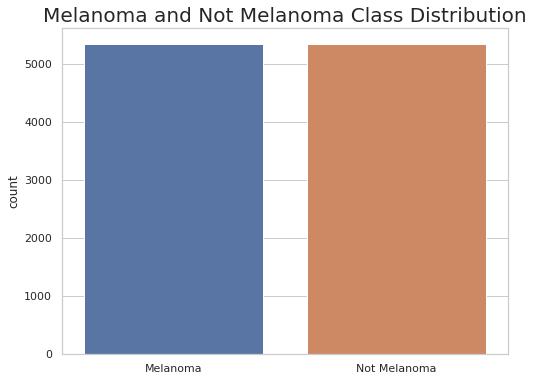

In [11]:
import seaborn as sns

# Creating a series of the training labels and mapping on readable names
class_labels = pd.Series(train_set.labels).map({0: 'Melanoma', 
                                                   1: 'Not Melanoma'})

# Plotting the distribution of the classes
fig, ax = plt.subplots(figsize=(8,6)) 
ax = sns.countplot(x=class_labels)
ax.set_title('Melanoma and Not Melanoma Class Distribution', 
             fontdict={'fontsize': 20});

In [12]:
def plotImages(images_arr):
  fig, axes = plt.subplots(1, 10, figsize=(20,20))
  axes = axes.flatten()
  for img, ax in zip(images_arr[:10], axes):
    ax.imshow(img)
    ax.axis('off')
  plt.tight_layout()
  plt.show()

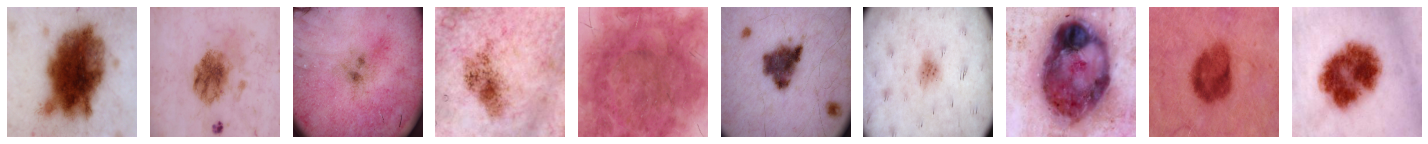

[[0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]]


In [13]:
plotImages(train_imgs)
print(train_labels[:10])

### Build Fine-Tuned EfficientNet Model

First Model

In [14]:
# Setting paramaters on early stopping
earlystop = EarlyStopping(monitor='val_acc',
                          patience=15,
                          verbose=1)

In [15]:
train_datagen = ImageDataGenerator(rotation_range=40,
                               shear_range=0.2,
                               zoom_range=0.2,
                               horizontal_flip=True,
                               preprocessing_function=preprocess_input)

test_datagen = ImageDataGenerator()

train_dataset = train_datagen.flow_from_directory(train_dir, 
                                    target_size=(224, 224),
                                    classes=['Melanoma', 'NotMelanoma'])

val_dataset = test_datagen.flow_from_directory(val_dir,
                                  target_size=(224, 224),
                                  classes=['Melanoma', 'NotMelanoma'])

test_dataset = test_datagen.flow_from_directory(test_dir,
                                   target_size=(224, 224),
                                   classes=['Melanoma', 'NotMelanoma'],
                                   shuffle=False)

Found 10682 images belonging to 2 classes.
Found 3562 images belonging to 2 classes.
Found 3561 images belonging to 2 classes.


In [16]:
effnet_model = EfficientNetB4(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

71696384/71686520 [==============================] - 1s 0us/step


In [17]:
effnet_model.summary()

Model: "efficientnetb4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 225, 225, 3)  0           ['normalization[0][0

In [18]:
#Convert the EfficientNetB4 model to a sequential model

effnet_1 = Sequential()
effnet_1.add(effnet_model)
effnet_1.add(layers.Flatten())
effnet_1.add(layers.Dropout(0.5))
effnet_1.add(layers.Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.001)))
effnet_1.add(layers.Dropout(0.5))
effnet_1.add(layers.Dense(2, activation='softmax'))

In [19]:
for layer in effnet_model.layers:
  layer.trainable = False

In [20]:
effnet_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb4 (Functional)  (None, 7, 7, 1792)       17673823  
                                                                 
 flatten (Flatten)           (None, 87808)             0         
                                                                 
 dropout (Dropout)           (None, 87808)             0         
                                                                 
 dense (Dense)               (None, 64)                5619776   
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 2)                 130       
                                                                 
Total params: 23,293,729
Trainable params: 5,619,906
Non

In [21]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
effnet_1.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])


In [24]:
log_dir = "/content/drive/MyDrive/Colab Notebooks/logs/fit/effnet_1"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [25]:
history_en1 = effnet_1.fit(train_dataset,
                       validation_data=val_dataset,
                       steps_per_epoch=100,
                       epochs=50,
                       callbacks=[earlystop, tensorboard_callback])

Epoch 1/50
100/100 [==============================] - 92s 921ms/step - loss: 0.5602 - acc: 0.8034 - val_loss: 0.4268 - val_acc: 0.8798
Epoch 2/50
100/100 [==============================] - 83s 832ms/step - loss: 0.4921 - acc: 0.8450 - val_loss: 0.4325 - val_acc: 0.8661
Epoch 3/50
100/100 [==============================] - 81s 809ms/step - loss: 0.4875 - acc: 0.8397 - val_loss: 0.3731 - val_acc: 0.8992
Epoch 4/50
100/100 [==============================] - 80s 804ms/step - loss: 0.4572 - acc: 0.8466 - val_loss: 0.3654 - val_acc: 0.8972
Epoch 5/50
100/100 [==============================] - 80s 800ms/step - loss: 0.4511 - acc: 0.8594 - val_loss: 0.3918 - val_acc: 0.8829
Epoch 6/50
100/100 [==============================] - 79s 793ms/step - loss: 0.4383 - acc: 0.8622 - val_loss: 0.3533 - val_acc: 0.9060
Epoch 7/50
100/100 [==============================] - 79s 795ms/step - loss: 0.4417 - acc: 0.8556 - val_loss: 0.3474 - val_acc: 0.9017
Epoch 8/50
100/100 [==============================] - 7

In [26]:
if os.path.isfile('/content/drive/MyDrive/Colab Notebooks/models/effnet_1.h5') is False:
  effnet_1.save('/content/drive/MyDrive/Colab Notebooks/models/effnet_1.h5')

In [27]:
effnet_1.evaluate(test_dataset)

112/112 [==============================] - 26s 233ms/step - loss: 0.3516 - acc: 0.8953


[0.35158637166023254, 0.8952541351318359]

In [28]:
pred_en1 = effnet_1.predict(test_dataset, verbose=0)
pred_en1

array([[0.9792117 , 0.0207883 ],
       [0.8866364 , 0.11336357],
       [0.992568  , 0.00743203],
       ...,
       [0.475014  , 0.524986  ],
       [0.06077826, 0.93922174],
       [0.4921894 , 0.50781065]], dtype=float32)

[[1436  345]
 [  28 1752]]


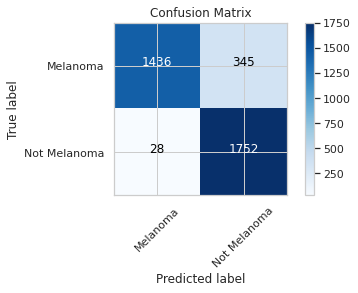

In [29]:
funct.plot_cm(y_true=test_dataset.classes, y_pred=np.argmax(pred_en1, axis=-1), classes=["Melanoma", "Not Melanoma"])

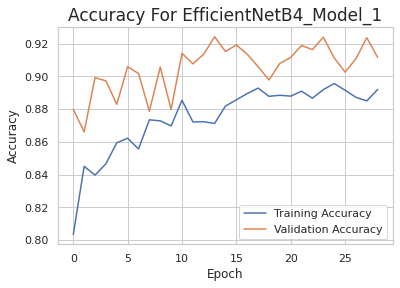

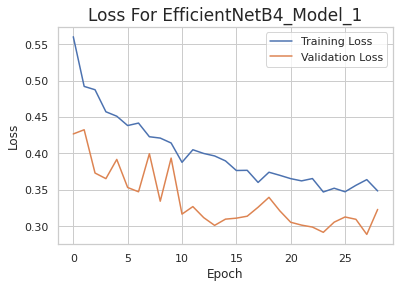

In [30]:
funct.plot_model_metrics(hist=history_en1, label='EfficientNetB4_Model_1')

### Second Model

In [31]:
train_idg = ImageDataGenerator(preprocessing_function=preprocess_input
                               )
val_idg = ImageDataGenerator(preprocessing_function=preprocess_input
                             )

train_gen = train_idg.flow_from_directory(train_dir, 
                                    target_size=(224, 224),
                                    classes=['Melanoma', 'NotMelanoma'])

val_gen = val_idg.flow_from_directory(val_dir,
                                  target_size=(224, 224),
                                  classes=['Melanoma', 'NotMelanoma'])

test_gen = val_idg.flow_from_directory(test_dir,
                                   target_size=(224, 224),
                                   classes=['Melanoma', 'NotMelanoma'],
                                   shuffle=False)

Found 10682 images belonging to 2 classes.
Found 3562 images belonging to 2 classes.
Found 3561 images belonging to 2 classes.


In [32]:
effnet_model2 = EfficientNetB4(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [33]:
effnet_2 = Sequential()
effnet_2.add(effnet_model2)
effnet_2.add(layers.Flatten())
effnet_2.add(layers.Dropout(0.5))
effnet_2.add(layers.Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.001)))
effnet_2.add(layers.Dropout(0.5))
effnet_2.add(layers.Dense(2, activation='softmax'))

In [34]:
for layer in effnet_model2.layers[:-2]:
  layer.trainable = False

In [35]:
effnet_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb4 (Functional)  (None, 7, 7, 1792)       17673823  
                                                                 
 flatten_1 (Flatten)         (None, 87808)             0         
                                                                 
 dropout_2 (Dropout)         (None, 87808)             0         
                                                                 
 dense_2 (Dense)             (None, 64)                5619776   
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 2)                 130       
                                                                 
Total params: 23,293,729
Trainable params: 5,623,490
N

In [36]:
effnet_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])


In [37]:
log_dir = "/content/drive/MyDrive/Colab Notebooks/logs/fit/effnet_2"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [38]:
history_en2 = effnet_2.fit(train_gen,
                       validation_data=val_gen,
                       steps_per_epoch=250,
                       epochs=50,
                       callbacks=[earlystop, tensorboard_callback])

Epoch 1/50
250/250 [==============================] - 100s 354ms/step - loss: 1.0024 - acc: 0.7976 - val_loss: 0.8802 - val_acc: 0.8922
Epoch 2/50
250/250 [==============================] - 84s 337ms/step - loss: 0.8819 - acc: 0.8469 - val_loss: 0.8296 - val_acc: 0.9062
Epoch 3/50
250/250 [==============================] - 84s 335ms/step - loss: 0.9470 - acc: 0.8568 - val_loss: 0.8244 - val_acc: 0.9034
Epoch 4/50
250/250 [==============================] - 84s 334ms/step - loss: 0.8576 - acc: 0.8556 - val_loss: 0.7378 - val_acc: 0.9060
Epoch 5/50
250/250 [==============================] - 84s 335ms/step - loss: 0.7145 - acc: 0.8775 - val_loss: 0.6513 - val_acc: 0.8995
Epoch 6/50
250/250 [==============================] - 83s 334ms/step - loss: 0.7037 - acc: 0.8760 - val_loss: 0.6385 - val_acc: 0.9093
Epoch 7/50
250/250 [==============================] - 84s 334ms/step - loss: 0.6726 - acc: 0.8777 - val_loss: 0.5758 - val_acc: 0.9166
Epoch 8/50
250/250 [==============================] - 

In [39]:
if os.path.isfile('/content/drive/MyDrive/Colab Notebooks/models/effnet_2.h5') is False:
  effnet_2.save('/content/drive/MyDrive/Colab Notebooks/models/effnet_2.h5')

In [40]:
effnet_2.evaluate(test_gen)

112/112 [==============================] - 25s 227ms/step - loss: 0.4254 - acc: 0.9141


[0.4253510534763336, 0.9140690565109253]

In [41]:
pred_en2 = effnet_2.predict(test_gen, verbose=0)
pred_en2

array([[9.9999726e-01, 2.7314334e-06],
       [9.9851149e-01, 1.4884816e-03],
       [9.9998224e-01, 1.7760742e-05],
       ...,
       [9.7053438e-01, 2.9465688e-02],
       [4.9867678e-02, 9.5013231e-01],
       [5.3569579e-01, 4.6430418e-01]], dtype=float32)

[[1563  218]
 [  88 1692]]


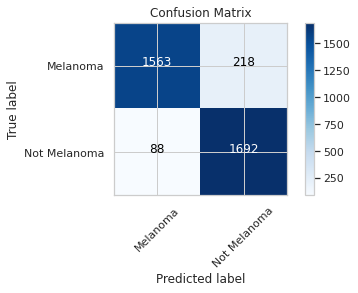

In [42]:
funct.plot_cm(y_true=test_gen.classes, y_pred=np.argmax(pred_en2, axis=-1), classes=["Melanoma", "Not Melanoma"])

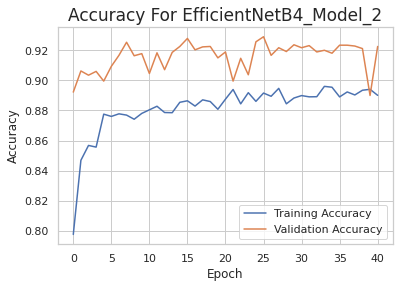

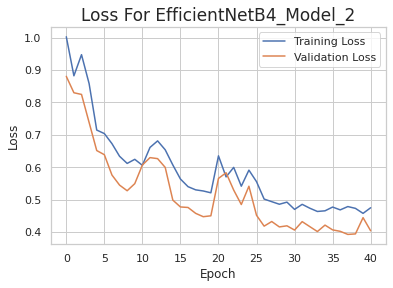

In [43]:
funct.plot_model_metrics(hist=history_en2, label='EfficientNetB4_Model_2')

### Third Model

In [44]:
effnet_model3 = EfficientNetB4(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [45]:
effnet_3 = Sequential()
effnet_3.add(effnet_model3)
effnet_3.add(layers.Flatten())
effnet_3.add(layers.Dropout(0.5))
effnet_3.add(layers.Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.001)))
effnet_3.add(layers.Dropout(0.5))
effnet_3.add(layers.Dense(2, activation='softmax'))

In [46]:
for layer in effnet_model3.layers[:-4]:
  layer.trainable = False

In [47]:
effnet_3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb4 (Functional)  (None, 7, 7, 1792)       17673823  
                                                                 
 flatten_2 (Flatten)         (None, 87808)             0         
                                                                 
 dropout_4 (Dropout)         (None, 87808)             0         
                                                                 
 dense_4 (Dense)             (None, 64)                5619776   
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 2)                 130       
                                                                 
Total params: 23,293,729
Trainable params: 6,426,306
N

In [48]:
effnet_3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])


In [49]:
log_dir = "/content/drive/MyDrive/Colab Notebooks/logs/fit/effnet_3"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [50]:
history_en3 = effnet_3.fit(train_gen,
                       validation_data=val_gen,
                       steps_per_epoch=100,
                       epochs=50,
                       callbacks=[earlystop, tensorboard_callback])

Epoch 1/50
100/100 [==============================] - 66s 550ms/step - loss: 1.2439 - acc: 0.7927 - val_loss: 0.6602 - val_acc: 0.8899
Epoch 2/50
100/100 [==============================] - 69s 689ms/step - loss: 0.7628 - acc: 0.8503 - val_loss: 0.6119 - val_acc: 0.8944
Epoch 3/50
100/100 [==============================] - 51s 508ms/step - loss: 0.6711 - acc: 0.8819 - val_loss: 0.6320 - val_acc: 0.8666
Epoch 4/50
100/100 [==============================] - 50s 504ms/step - loss: 0.6266 - acc: 0.8820 - val_loss: 0.5480 - val_acc: 0.9079
Epoch 5/50
100/100 [==============================] - 50s 504ms/step - loss: 0.6027 - acc: 0.8900 - val_loss: 0.5348 - val_acc: 0.9124
Epoch 6/50
100/100 [==============================] - 51s 507ms/step - loss: 0.6059 - acc: 0.8622 - val_loss: 0.4898 - val_acc: 0.9191
Epoch 7/50
100/100 [==============================] - 50s 505ms/step - loss: 0.5304 - acc: 0.8995 - val_loss: 0.4945 - val_acc: 0.9102
Epoch 8/50
100/100 [==============================] - 5

In [51]:
if os.path.isfile('/content/drive/MyDrive/Colab Notebooks/models/effnet_3.h5') is False:
  effnet_3.save('/content/drive/MyDrive/Colab Notebooks/models/effnet_3.h5')

In [52]:
effnet_3.evaluate(test_gen)

112/112 [==============================] - 24s 219ms/step - loss: 0.3708 - acc: 0.9318


[0.3708295226097107, 0.9317607283592224]

In [53]:
pred_en3 = effnet_3.predict(test_gen, verbose=0)
pred_en3

array([[1.0000000e+00, 1.3364411e-08],
       [9.9995351e-01, 4.6436122e-05],
       [1.0000000e+00, 1.0640471e-09],
       ...,
       [6.4922410e-01, 3.5077593e-01],
       [4.3099929e-02, 9.5690006e-01],
       [4.3770292e-01, 5.6229711e-01]], dtype=float32)

[[1643  138]
 [ 105 1675]]


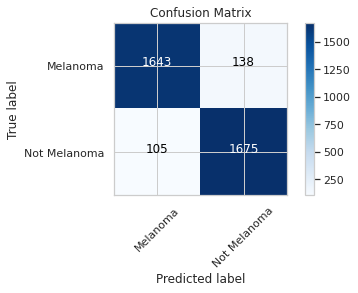

In [54]:
funct.plot_cm(y_true=test_gen.classes, y_pred=np.argmax(pred_en3, axis=-1), classes=["Melanoma", "Not Melanoma"])

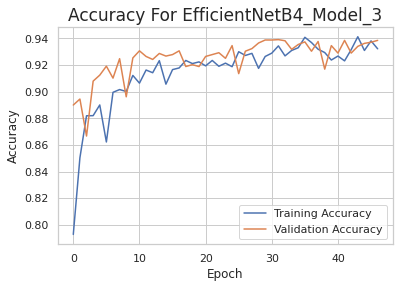

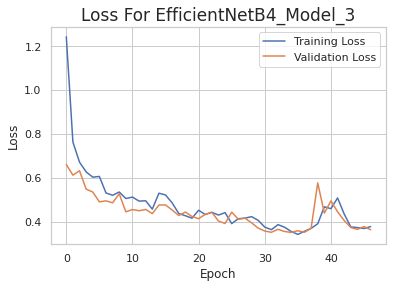

In [55]:
funct.plot_model_metrics(hist=history_en3, label='EfficientNetB4_Model_3')